In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12.0, 7.0)
# sns.set_palette("Set1")

In [4]:
data = pd.read_csv("./AllBooks_baseline_DTM_Labelled.csv")

data.rename({"Unnamed: 0" : "Title"}, axis='columns', inplace=True)

data.set_index("Title", inplace=True)

## 1 General statistics

In [5]:
data.shape

(590, 8266)

In [6]:
data.head()

,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,convict,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
Title,,,,,,,,,,,,,,,,,,,,,
Buddhism_Ch1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data.index.to_series().str.split("_", expand=True)[0].unique().tolist()

['Buddhism',
 'TaoTeChing',
 'Upanishad',
 'YogaSutra',
 'BookOfProverb',
 'BookOfEcclesiastes',
 'BookOfEccleasiasticus',
 'BookOfWisdom']

In [8]:
non_zero_perc = data.astype('bool').sum().sum() / (data.shape[0] * data.shape[1]) * 100
print(f"{ 100 - round(non_zero_perc, 2)}% of data are zeros")     

99.14% of data are zeros


In [9]:
unique_word_perc = (data.sum(axis=0) == 1).sum() / data.shape[1]
print(f"{100 * round(unique_word_perc, 2)}% of the words appear only once")

43.0% of the words appear only once


In [10]:
sub_100_word_perc = (data.sum(axis=1) < 100).sum() / data.shape[0]
print(f"{100 * round(sub_100_word_perc, 2)}% of the chapters have fewer than 100 words")

70.0% of the chapters have fewer than 100 words


In [11]:
data.sum(axis=0).sort_values(ascending=False)

shall         1168
man            846
thy            645
one            473
things         468
              ... 
actuates         1
luxurious        1
courageous       1
babes            1
successors       1
Length: 8266, dtype: int64

In [12]:
data.sum(axis=1).sort_values(ascending=False)

Title
Buddhism_Ch37                 1194
BookOfEccleasiasticus_Ch47     557
Buddhism_Ch42                  522
BookOfEccleasiasticus_Ch23     414
BookOfEccleasiasticus_Ch24     400
                              ... 
Upanishad_Ch128                  8
Upanishad_Ch103                  7
Upanishad_Ch125                  7
Upanishad_Ch143                  6
Buddhism_Ch14                    0
Length: 590, dtype: int64

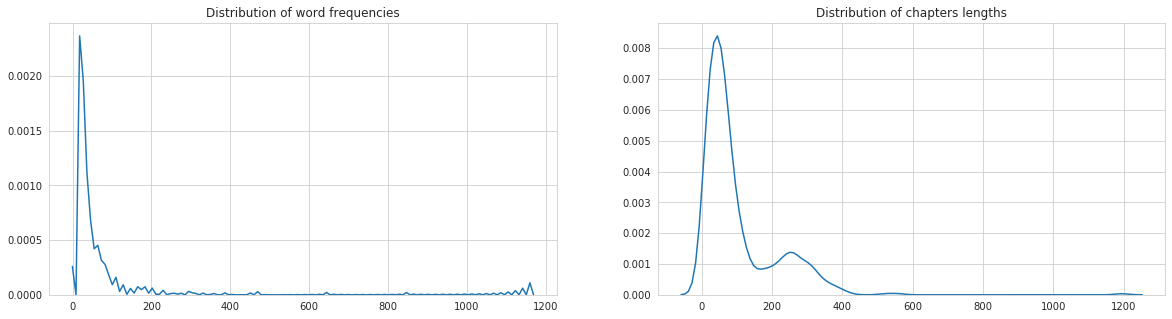

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))

sns.distplot(data.sum(axis=0), hist=False, ax=ax[0]).set_title('Distribution of word frequencies')
sns.distplot(data.sum(axis=1), hist=False, ax=ax[1]).set_title('Distribution of chapters lengths');

In [14]:
data['Book'] = data.index.to_series().str.split("_", expand=True)[0]

In [15]:
data.Book.replace(
    {
        "BookOfProverb": "Bible",
        "BookOfWisdom": "Bible",
        "BookOfEccleasiasticus": "Bible",
        "BookOfEcclesiastes": "Bible"
    },
    inplace=True)

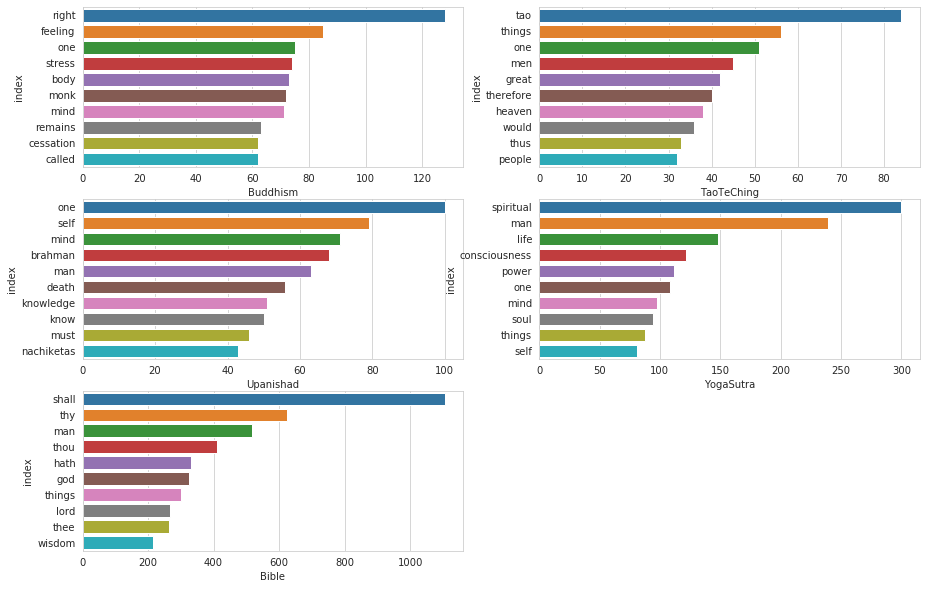

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), sharex=False)
fig.delaxes(axes[2][1])

axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx == 5: break
    plt.sca(ax)

    ax = sns.barplot(
        y='index',
        x=data.Book.unique()[idx],
        data=data.groupby('Book').sum().T[data.Book.unique()[idx]].sort_values(
            ascending=False).head(10).reset_index())
    

In [17]:
# Removing one chapter without words
data.drop(data[data.sum(axis=1) == 0].index, inplace=True)

In [18]:
# Removing one and two letter words
data = data.loc[:, [word for word in data.columns.to_list() if len(word) > 2]]

In [19]:
# Problematic word for parts of speech analysis
data.drop('theres', axis=1, inplace=True)

In [20]:
data.set_index("Book", inplace=True)

## 2 Feature engineering

In [21]:
def get_word_list(count_vector):
    return sum([[word] * count for word, count in zip(data.columns, count_vector)], [])

In [22]:
data['word_list'] = data.apply(lambda x: get_word_list(x), axis=1)

data['n_words'] = data.word_list.str.len()

data['unique_word_list'] = data.word_list.apply(lambda x: list(set(x)))

data['n_unique_words'] = data.unique_word_list.str.len()

data['long_word_freq'] = data.word_list.apply(lambda x: len([word for word in x if len(word) > 12]) / len(x))

data['mean_word_length'] = data.word_list.apply(lambda x: np.mean([len(word) for word in x]))

In [23]:
def get_single_use_word_freq(word_list):
    return Counter(Counter(word_list).values())[1] / len(word_list)

In [24]:
data['single_use_word_freq'] = data.word_list.apply(lambda x: get_single_use_word_freq(x))

In [25]:
data.reset_index(inplace=True)

In [26]:
def plot_box_swarm_kde(feature, bw=0.1, use_violin=False):

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    #     sorted_index = data.groupby('Book')[feature].mean().sort_values().index

    if use_violin:
        sns.violinplot(x="Book", y=feature, data=data, bw=0.2,
                       ax=ax[0]).set_title(feature + " distribution")
    else:
        sns.boxplot(x="Book", y=feature, data=data,
                    ax=ax[0]).set_title(feature + " distribution")

    sns.swarmplot(x="Book", y=feature, data=data, size=3, color=".3", ax=ax[0])

    # Density plot for each book
    for book in data.Book.unique():

        subset = data[data.Book == book]
        
        sns.kdeplot(subset[feature], label=book, bw=bw, ax=ax[1])
        
    plt.tight_layout()

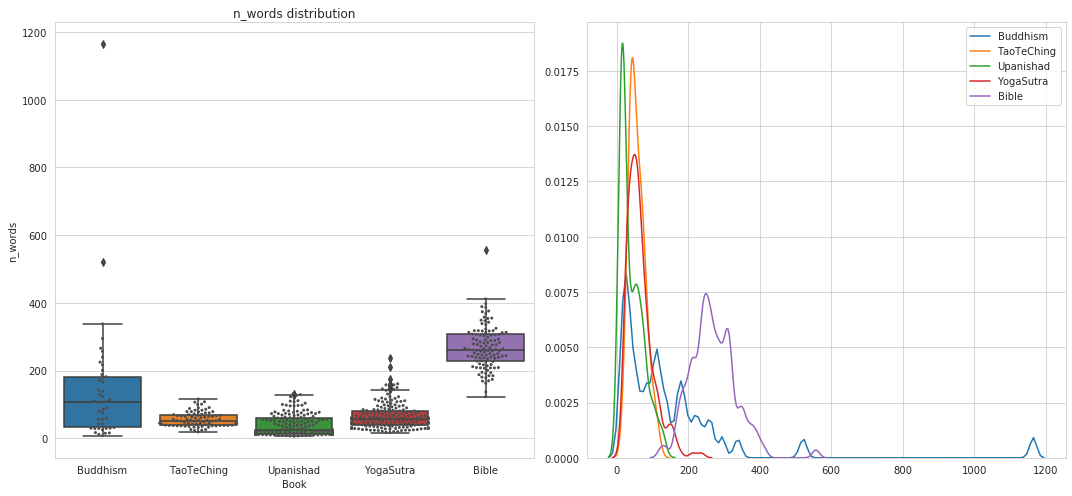

In [27]:
plot_box_swarm_kde(feature='n_words', bw=10)

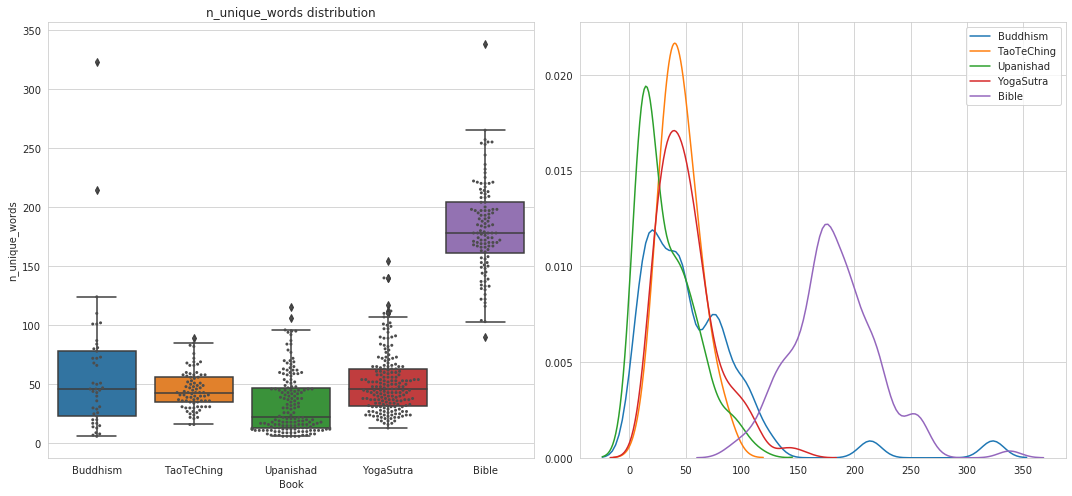

In [28]:
plot_box_swarm_kde(feature='n_unique_words', bw=10)

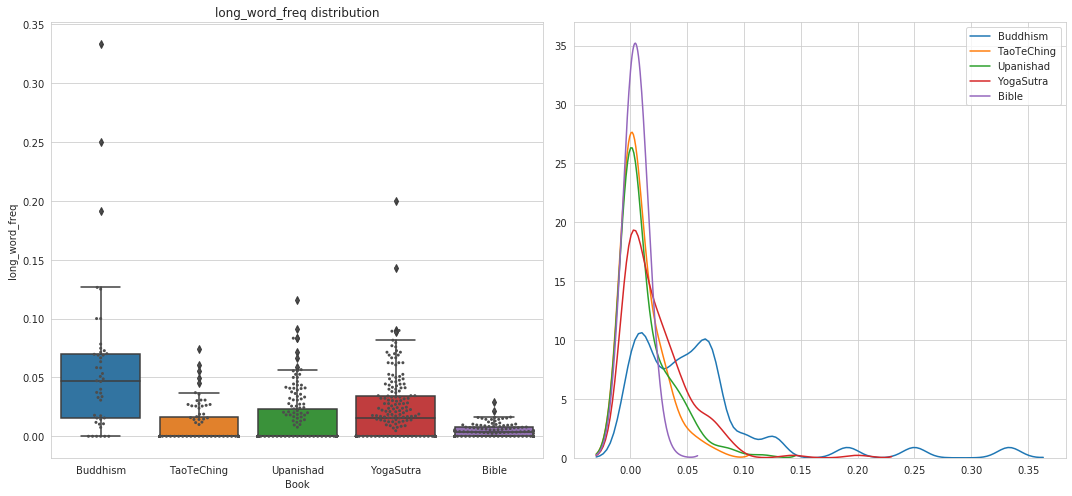

In [29]:
plot_box_swarm_kde(feature='long_word_freq', bw=0.01)

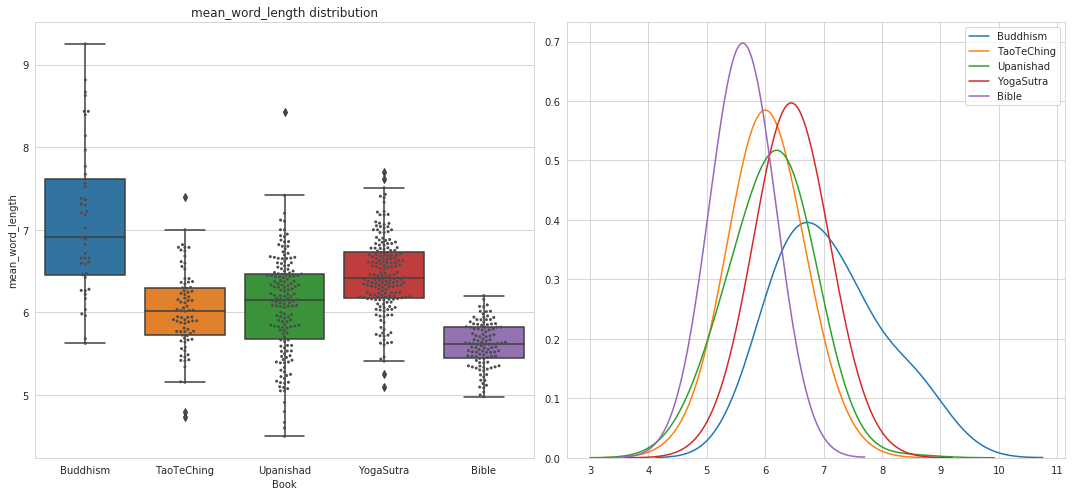

In [30]:
plot_box_swarm_kde(feature='mean_word_length', bw=0.5)

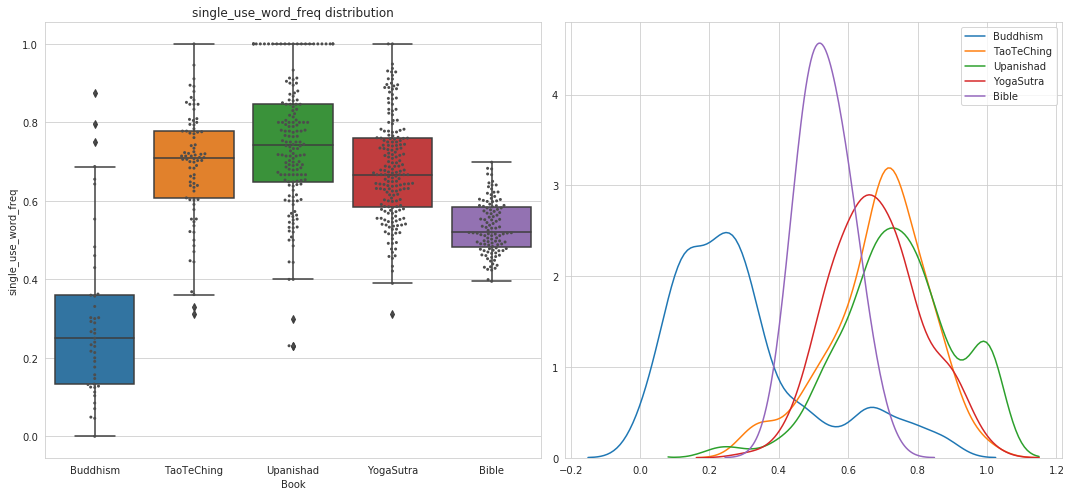

In [31]:
plot_box_swarm_kde(feature='single_use_word_freq', bw=0.05)

In [32]:
# Most common word endings, eth stands out as not that common in modern english
from collections import Counter
Counter([word[-3:] for word in data.columns.to_list()]).most_common(10)

[('ing', 648),
 ('eth', 389),
 ('ion', 289),
 ('ess', 215),
 ('ted', 190),
 ('ent', 150),
 ('nce', 124),
 ('ons', 114),
 ('ble', 114),
 ('est', 105)]

In [33]:
# Many old english words, may be a good indicator for certain books
Counter([word for word in data.columns.to_list() if word.endswith('eth')]).most_common(10)

[('expecteth', 1),
 ('looketh', 1),
 ('approveth', 1),
 ('sweareth', 1),
 ('prepareth', 1),
 ('possesseth', 1),
 ('reserveth', 1),
 ('decreaseth', 1),
 ('deviseth', 1),
 ('pricketh', 1)]

In [34]:
custom_ends = ['eth']

In [35]:
for custom_end in custom_ends:
    data[custom_end + "_freq"] = data.word_list.apply(lambda x: len([word for word in x if word.endswith(custom_end)]) / len(x))

In [36]:
data.groupby('Book')['eth_freq'].sum() 

Book
Bible         4.459517
Buddhism      0.003817
TaoTeChing    0.000000
Upanishad     0.007874
YogaSutra     0.214352
Name: eth_freq, dtype: float64

## Parts of speech

In [37]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Document containing all words
doc = nlp(" ".join(data.columns.tolist()))

In [38]:
# Filling dataframe with parts of speech data
parts_of_speech = pd.DataFrame(columns= ['text', 'pos', 'tag'])

for token in doc:
    row = [token.text, token.pos_, token.tag_]
    row = pd.Series(row, index = parts_of_speech.columns)
    parts_of_speech = parts_of_speech.append(row, ignore_index=True)


parts_of_speech.set_index('text', inplace=True)

In [39]:
# Example of adjecitves found in books
parts_of_speech[parts_of_speech.pos == 'ADJ'].index.tolist()[:10]

['takest',
 'open',
 'unbridled',
 'prosperous',
 'soft',
 'filial',
 'conceal',
 'argumentative',
 'valuable',
 'visible']

In [40]:
# Merging parts of speech that appear fewer than 100 times into OTHER category
pos_to_merge = parts_of_speech.groupby('pos').filter(lambda x: len(x) < 100)['pos'].unique()

parts_of_speech['clean_pos'] = np.where(np.isin(parts_of_speech['pos'], pos_to_merge), 'OTHER', parts_of_speech['pos'])

In [41]:
def word_list_to_pos_list(word_list):
    return np.array([parts_of_speech.loc[word]['clean_pos'] for word in word_list])

In [42]:
data['pos_list'] = data.word_list.apply(lambda x: word_list_to_pos_list(x))

In [43]:
unique_pos = parts_of_speech.clean_pos.unique()

In [44]:
# Creating frequencies of pos occurences in books
for pos in unique_pos:
    data[pos + "_freq"] = data.pos_list.apply(lambda x: (x == pos)).apply(
        lambda x: np.mean(x))

In [45]:
pos_cloumns = ['PROPN_freq', 'NOUN_freq', 'ADJ_freq', 'VERB_freq', 'ADV_freq', 'OTHER_freq']

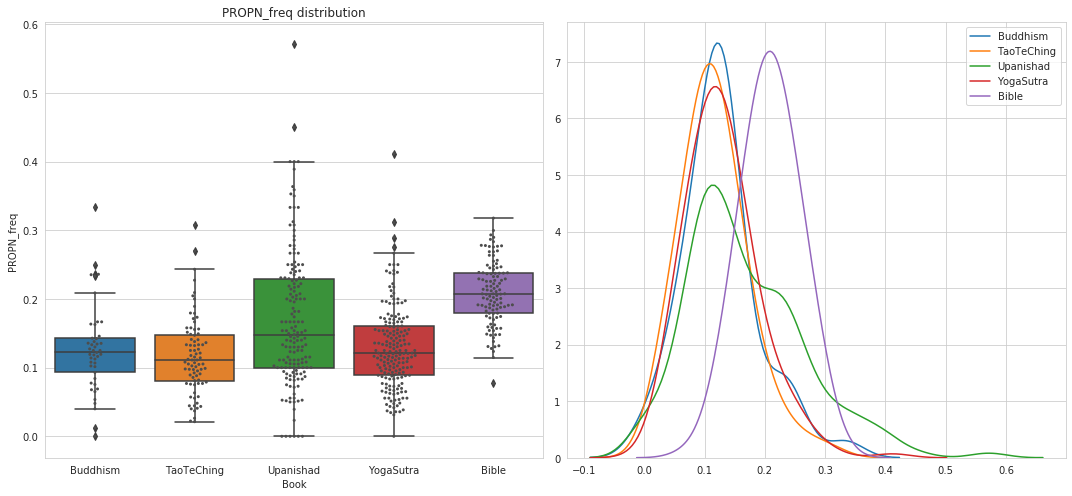

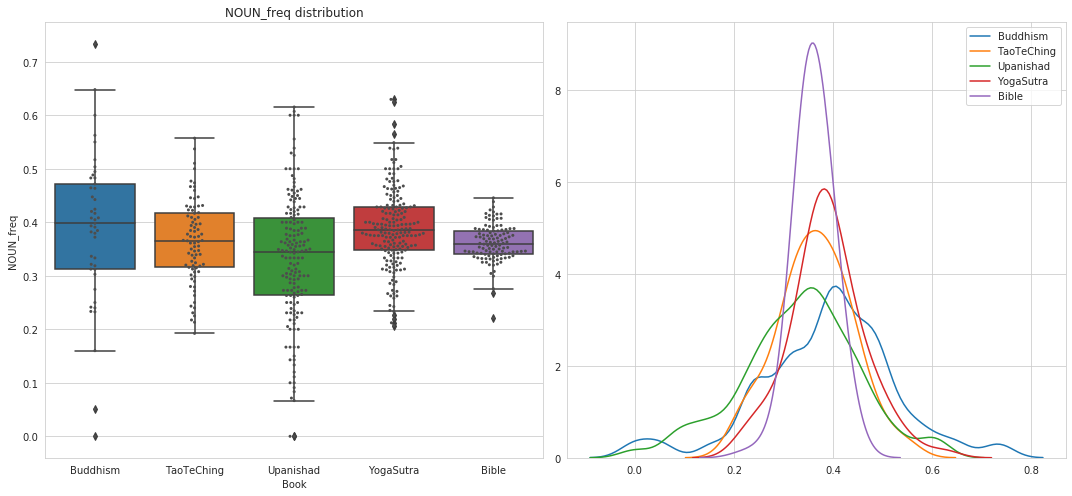

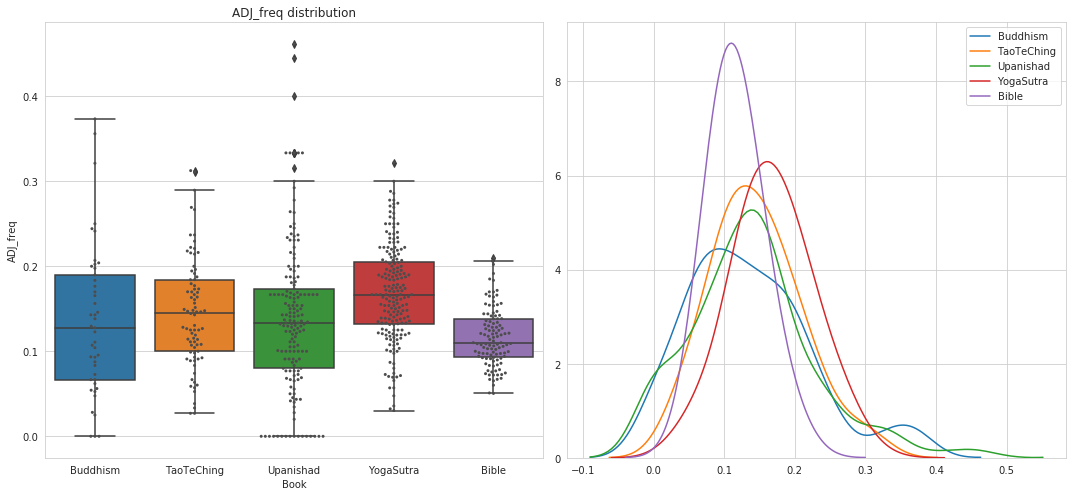

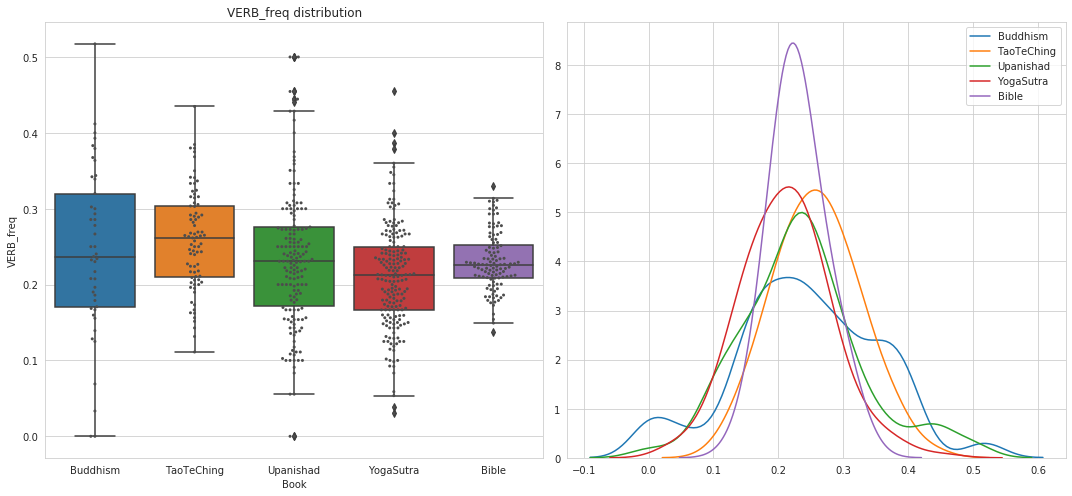

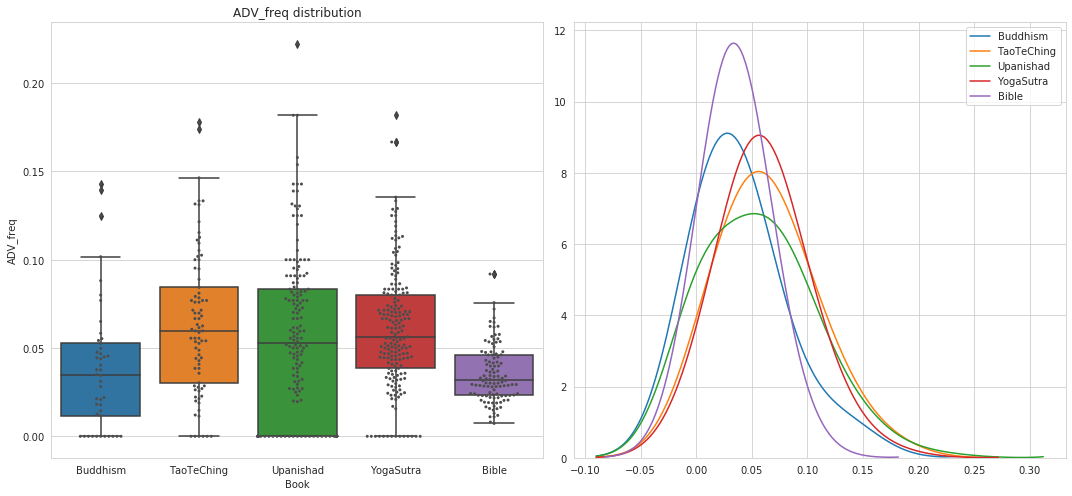

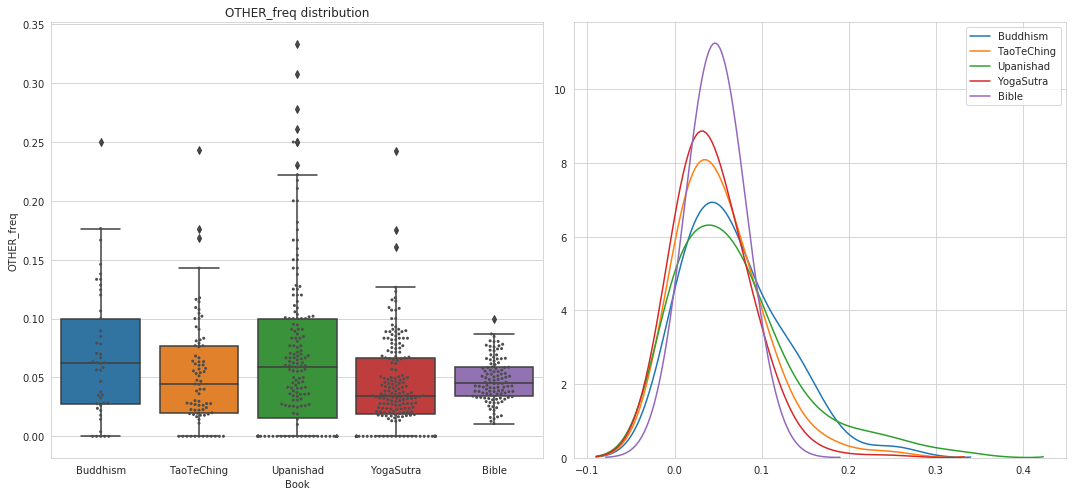

In [46]:
for pos in pos_cloumns:
    plot_box_swarm_kde(feature=pos, bw=0.03)

## Other

In [47]:
data.groupby("Book")[["good", "evil"]].sum().reset_index()

,Book,good,evil
0,Bible,189,130
1,Buddhism,5,2
2,TaoTeChing,16,7
3,Upanishad,11,1
4,YogaSutra,6,5


In [48]:
 data.groupby("Book")[["heart", "soul"]].sum().reset_index()

,Book,heart,soul
0,Bible,194,148
1,Buddhism,4,0
2,TaoTeChing,0,0
3,Upanishad,31,19
4,YogaSutra,43,94


In [49]:
 data.groupby("Book")[["life", "death"]].sum().reset_index()

,Book,life,death
0,Bible,144,87
1,Buddhism,22,13
2,TaoTeChing,16,17
3,Upanishad,27,56
4,YogaSutra,148,10


In [50]:
 data.groupby("Book")[["man", "woman"]].sum().reset_index()

,Book,man,woman
0,Bible,517,66
1,Buddhism,11,1
2,TaoTeChing,16,0
3,Upanishad,63,0
4,YogaSutra,239,0


In [51]:
 data.groupby("Book")[["god", "devil"]].sum().reset_index()

,Book,god,devil
0,Bible,325,3
1,Buddhism,0,0
2,TaoTeChing,1,0
3,Upanishad,31,0
4,YogaSutra,28,0


## Sentiment analysis

In [52]:
import polyglot
from polyglot.text import Text, Word
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

In [53]:
def get_polarity(word_list): 
    return np.mean([word.polarity for word in Text(" ".join(word_list)).words if word.polarity != 0])

In [54]:
data['polarity'] = data.word_list.apply(lambda x: get_polarity(x))

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


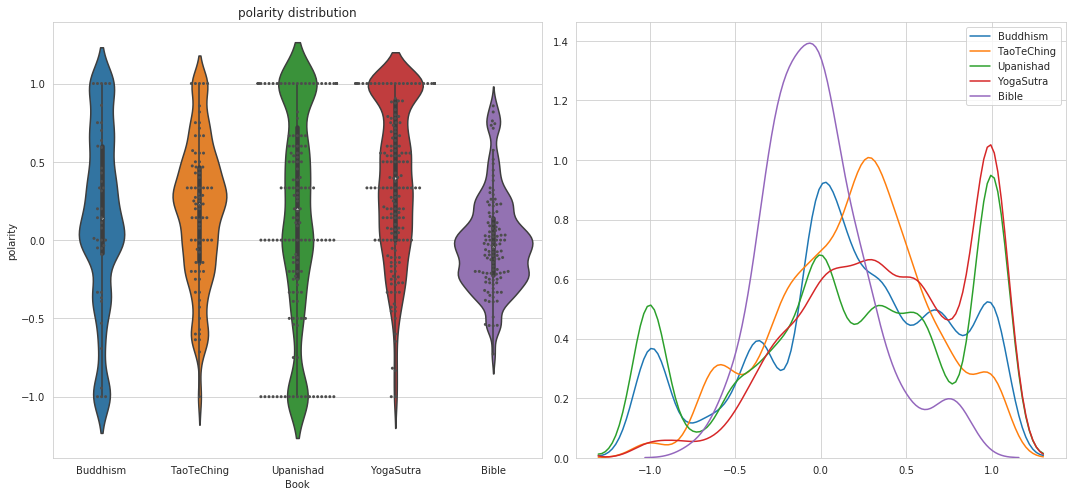

In [55]:
plot_box_swarm_kde(feature='polarity', bw=0.1, use_violin=True)

In [56]:
def get_polarity_blob(word_list):
    return TextBlob(" ".join(word_list)).sentiment.polarity

In [57]:
data['polarity_blob'] = data.word_list.apply(lambda x: get_polarity_blob(x))

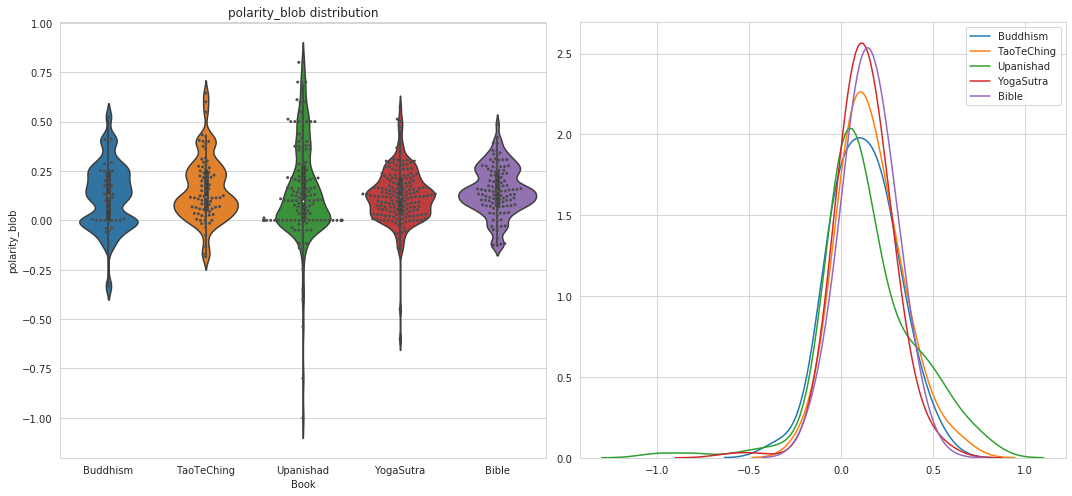

In [58]:
plot_box_swarm_kde(feature='polarity_blob', bw=0.1, use_violin=True)

In [59]:
def get_subjectivity(word_list):
    return TextBlob(" ".join(word_list)).sentiment.subjectivity

In [60]:
data['subjectivity'] = data.word_list.apply(lambda x: get_subjectivity(x))

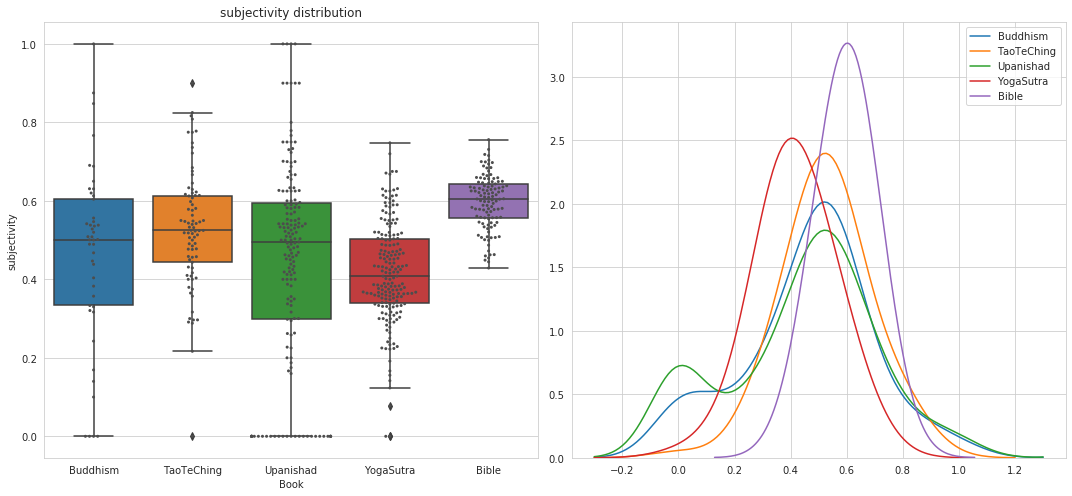

In [61]:
plot_box_swarm_kde(feature='subjectivity', bw=0.1, use_violin=False)

## Emotions analysis

In [62]:
 lexicon = pd.read_csv("./NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", sep="\t", names=["word", "emotion", "association"])

In [63]:
# Preparing lexicon for emotions search
lexicon.set_index('word', inplace=True)

EMOTIONS = lexicon.emotion.unique().tolist()

lexicon = lexicon[lexicon.association != 0]

lexicon = lexicon.groupby(
    lexicon.index)['emotion'].apply(lambda x: list(x)).to_frame()

In [64]:
# Extracting emotions from word list
def get_emotions(word_list):

    list_of_lists = [lexicon.loc[word, 'emotion'] for word in word_list if word in lexicon.index.unique()]

    return [y for x in list_of_lists for y in x]

In [65]:
data['emotions_list'] = data.word_list.apply(lambda x: get_emotions(x))

In [66]:
# Calculationg frequencie of given emotion in emotions list
def get_emotion_freq(emotions_list, emotion):
    try:
        return Counter(emotions_list)[emotion] / len(emotions_list)
    except:
        return 0

In [67]:
for emotion in EMOTIONS:
    data[emotion + '_freq'] = data.emotions_list.apply(lambda x: get_emotion_freq(x, emotion))

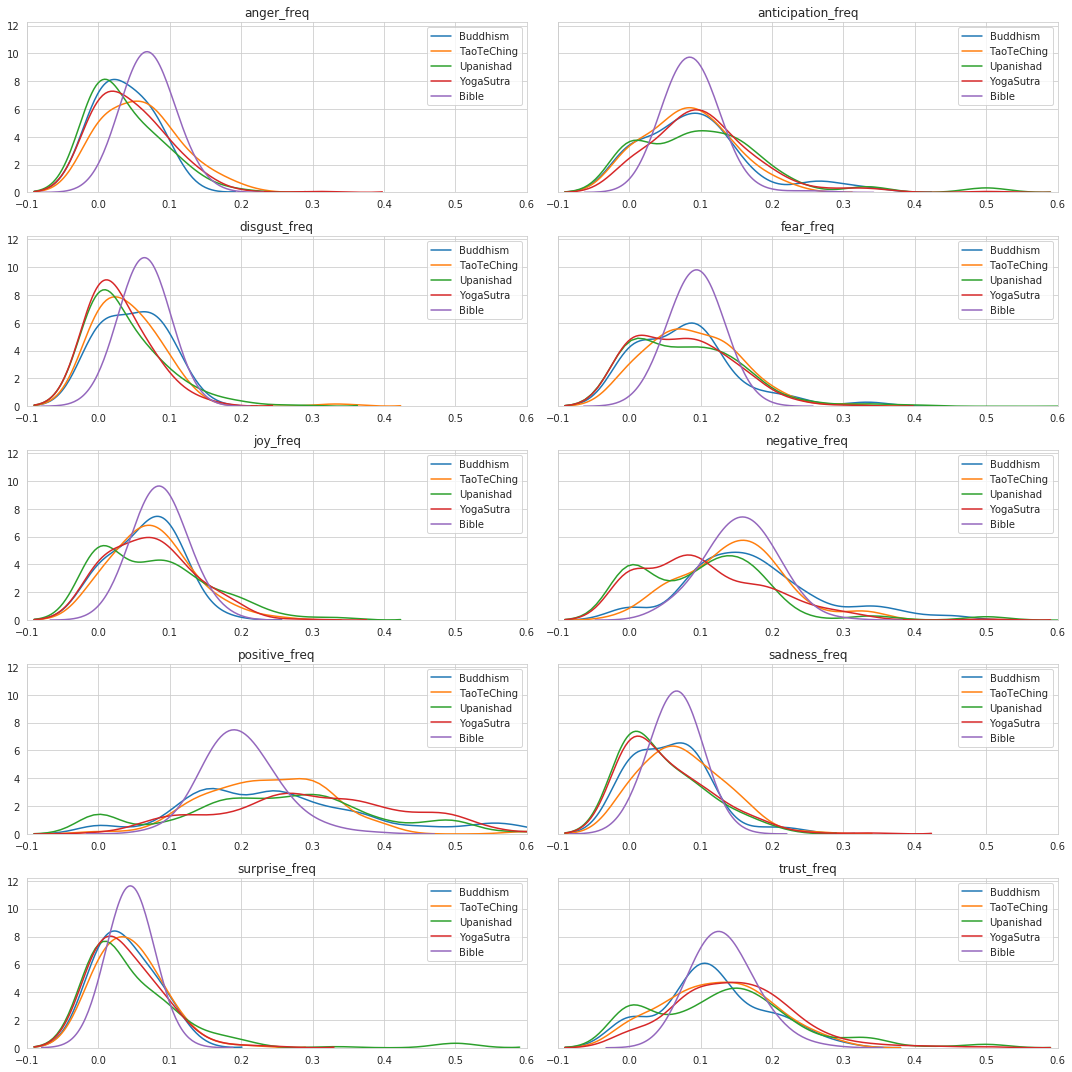

In [68]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15), sharey=True)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    plt.sca(ax) 

    for book in data.Book.unique():

        subset = data[data.Book == book]
        plt.xlim(-0.1, 0.6)
        ax = sns.kdeplot(subset[EMOTIONS[idx] + "_freq"], label=book, bw=0.03).set_title(EMOTIONS[idx] + "_freq")
        
plt.tight_layout()

## Named entities

In [69]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [70]:
def get_named_entities_freq(word_list):
    return len([entity.label_ for entity in nlp(" ".join(word_list)).ents]) / len(word_list)

In [71]:
data['named_entities_freq'] = data.word_list.apply(lambda x: get_named_entities_freq(x)) 

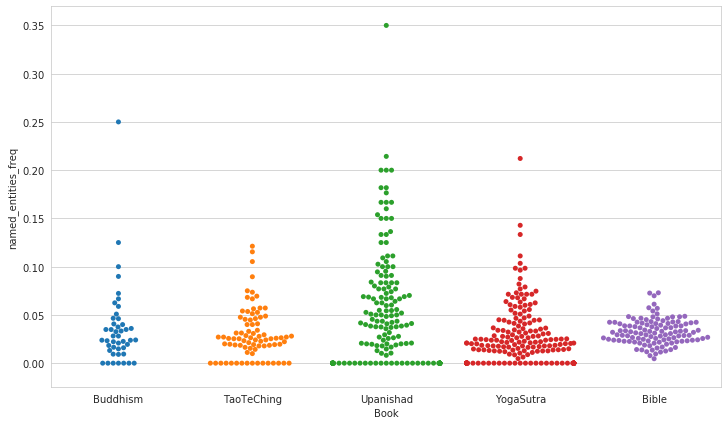

In [72]:
sns.swarmplot(x='Book', y='named_entities_freq', data=data);

In [73]:
# Creating dictionary of named entities found in books
from collections import defaultdict 
  
LABELS_DICT = defaultdict(set) 

for word in data.columns.to_list():
    doc = nlp(word)

    for e in doc.ents:
        LABELS_DICT[e.label_].add(e.text)

In [74]:
LABELS_DICT['PERSON']

{'aaron',
 'apana',
 'darwin',
 'david',
 'dealiug',
 'dung',
 'john',
 'jordan',
 'joseph',
 'juda',
 'samuel'}

In [75]:
LABELS_DICT['GPE']

{'boston',
 'dreamland',
 'egypt',
 'emblem',
 'india',
 'israel',
 'jerusalem',
 'thine'}

## Similarity between words

In [76]:
spacy.load('en_core_web_md');

In [77]:
import en_core_web_md
nlp = en_core_web_md.load()

In [78]:
data.set_index('Book', inplace=True)

In [79]:
# Only first 20 words for test
tokens = nlp(" ".join(data.columns.to_list()[:20]))

In [80]:
similarity_matrix = pd.DataFrame(0, index=data.columns.to_list()[:20], columns=data.columns.to_list()[:20])

In [81]:
for i in range(20):
    for j in range(20):
        similarity_matrix.iloc[i, j] = tokens[i].similarity(tokens[j])

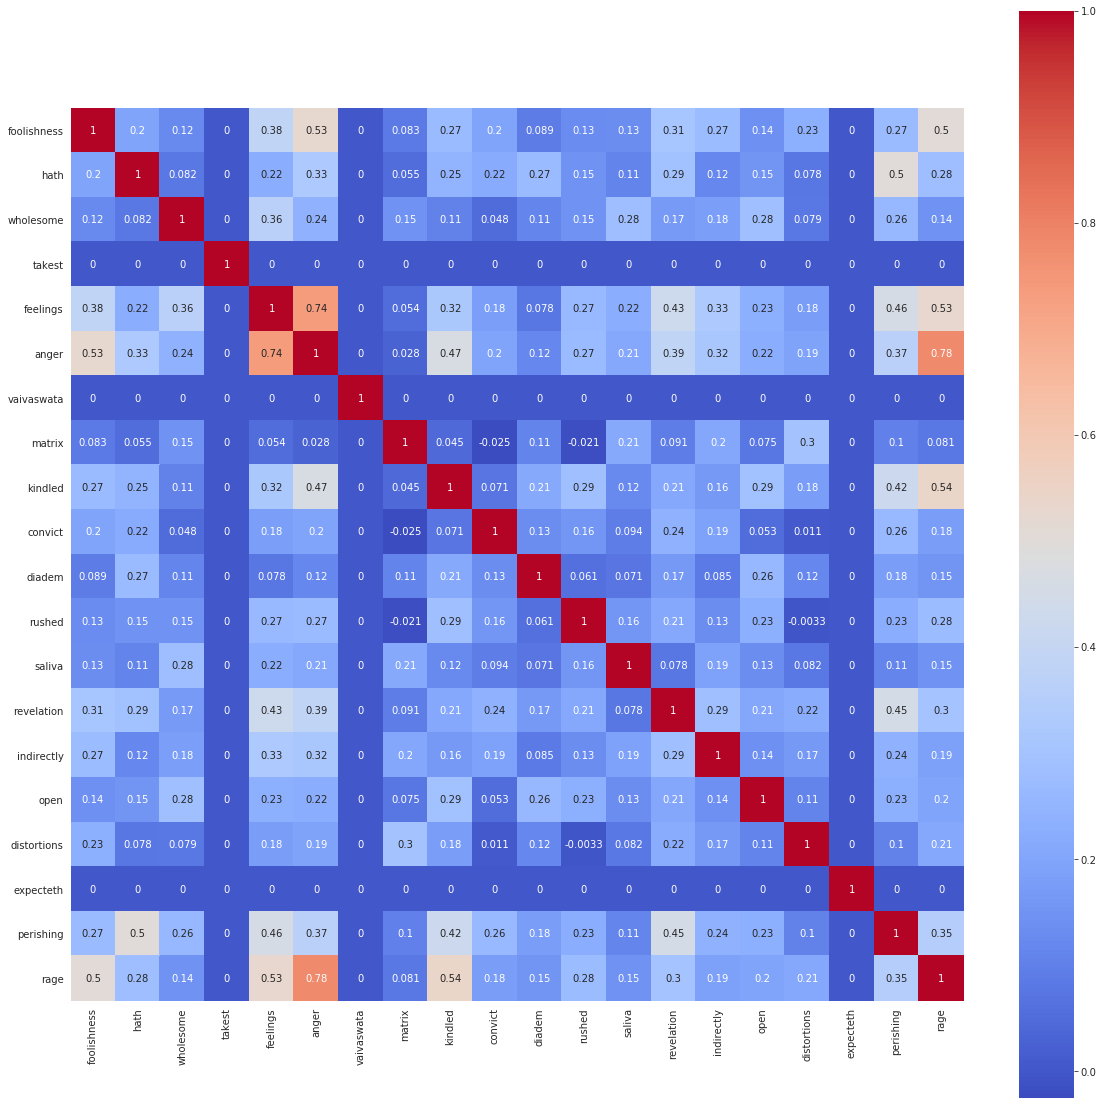

In [82]:
plt.figure(figsize=(20, 20))

sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", square=True);

## PCA

In [83]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [84]:
data_pca = data.iloc[:, -29:].drop(['unique_word_list', 'pos_list', 'emotions_list', 'polarity_blob'] , axis=1)

In [85]:
pd.set_option('display.max_columns', 30)

data_pca

,n_words,n_unique_words,long_word_freq,mean_word_length,single_use_word_freq,eth_freq,PROPN_freq,NOUN_freq,ADJ_freq,VERB_freq,ADV_freq,OTHER_freq,polarity,subjectivity,anger_freq,anticipation_freq,disgust_freq,fear_freq,joy_freq,negative_freq,positive_freq,sadness_freq,surprise_freq,trust_freq,named_entities_freq
Book,,,,,,,,,,,,,,,,,,,,,,,,,
Buddhism,295,87,0.037288,6.596610,0.125424,0.000000,0.145763,0.274576,0.189831,0.277966,0.088136,0.023729,0.111111,0.403750,0.063492,0.052910,0.105820,0.116402,0.095238,0.126984,0.179894,0.105820,0.015873,0.137566,0.023729
Buddhism,106,47,0.047170,6.584906,0.132075,0.000000,0.075472,0.471698,0.169811,0.207547,0.037736,0.037736,0.000000,0.620000,0.019608,0.019608,0.039216,0.000000,0.058824,0.294118,0.313725,0.000000,0.019608,0.235294,0.009434
Buddhism,188,81,0.010638,6.260638,0.292553,0.000000,0.047872,0.494681,0.127660,0.250000,0.021277,0.058511,-0.531250,0.547078,0.026549,0.070796,0.026549,0.097345,0.008850,0.451327,0.123894,0.088496,0.035398,0.070796,0.015957
Buddhism,129,50,0.015504,6.658915,0.147287,0.000000,0.116279,0.488372,0.062016,0.217054,0.054264,0.062016,0.314286,0.688265,0.018692,0.056075,0.000000,0.028037,0.018692,0.186916,0.373832,0.018692,0.009346,0.289720,0.023256
Buddhism,15,8,0.333333,8.666667,0.266667,0.000000,0.133333,0.733333,0.000000,0.000000,0.000000,0.133333,-1.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.111111,0.222222,0.111111,0.111111,0.000000,0.222222,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bible,236,174,0.000000,5.669492,0.563559,0.067797,0.237288,0.385593,0.144068,0.161017,0.033898,0.038136,-0.024390,0.645000,0.045752,0.117647,0.039216,0.091503,0.124183,0.130719,0.196078,0.065359,0.032680,0.156863,0.042373
Bible,376,232,0.005319,5.800532,0.428191,0.023936,0.236702,0.321809,0.074468,0.268617,0.047872,0.050532,-0.200000,0.572803,0.097378,0.067416,0.067416,0.149813,0.067416,0.183521,0.164794,0.059925,0.026217,0.116105,0.026596
Bible,246,197,0.012195,6.158537,0.682927,0.012195,0.077236,0.325203,0.158537,0.308943,0.065041,0.065041,-0.545455,0.715508,0.141361,0.068063,0.052356,0.167539,0.026178,0.246073,0.073298,0.130890,0.036649,0.057592,0.016260


In [86]:
# Filling missing data in polarity
data_pca.fillna(0, inplace=True)

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [88]:
data_pca = pd.DataFrame(scaler.fit_transform(data_pca), columns=data_pca.columns)

In [89]:
data_pca.set_index(data.index, inplace=True)

In [90]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_pca)
data_pca['pca-one'] = pca_result[:,0]
data_pca['pca-two'] = pca_result[:,1] 
data_pca['pca-three'] = pca_result[:,2]

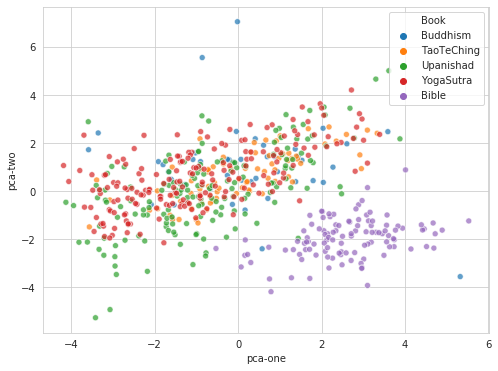

In [91]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca-one",
                y="pca-two",
                hue=data_pca.index,
                data=data_pca,
                legend="full",
                alpha=0.7);

In [92]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_pca)

In [93]:
data_pca['tsne-2d-one'] = tsne_results[:,0]
data_pca['tsne-2d-two'] = tsne_results[:,1]

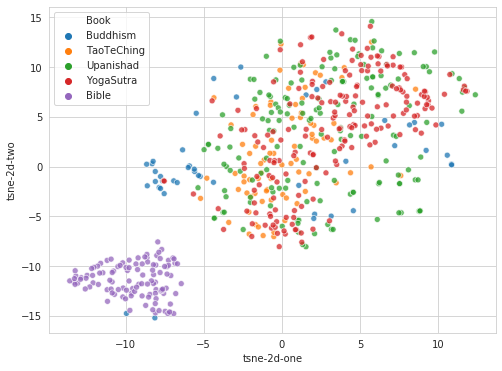

In [94]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=data_pca.index,
    data=data_pca,
    legend="full",
    alpha=0.75);

In [95]:
# Lematizing
lemmas = list(set([token.lemma_ for token in nlp(" ".join(data.columns.to_list()))]))

print(f"Lemmatizing decreases corpus size by {data.shape[1] - len(lemmas)} words")

Lemmatizing decreases corpus size by 1958 words


Conclusions:
 - Bible is visible different than other books, can be easily separated
 - original data is very sparse, feature engineering and/or dimensionality reduction is necessary for proper clustering
 - incorporating whole texts instead of limited preprocessed corpus might be helpful, can provide context aware features
 - features based on clustering similar words might help